# Bayesian Learning
![NB](images/06_bayes.jpg)

Note, we'll use another library in this notebook: [GPy](http://sheffieldml.github.io/GPy/)

Installation:
```
pip install GPy
pip install pods
```

In [1]:
# Global imports and settings
from preamble import *
%matplotlib inline
plt.rcParams['savefig.dpi'] = 300 # Use 300 for PDF, 100 for slides
#InteractiveShell.ast_node_interactivity = "all"
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

In [2]:
import GPy
import pods

## Naive Bayes
Predict the probability that a point belongs to each class, using Bayes' Theorem, assuming that the features are independent from each other.

Very fast: only needs to extract statistics from each feature.

### Naive Bayes Classifier
A Naive Bayes classifier learns the joint probability $P(x,c) = P(x|c)P(c)$ of the data, and predicts the class of each sample using Bayes' rule:

![Bayes Rule](images/06_bayes_rule.png)

$P(c|x)$ is the posterior probability of class (target) given predictor (attribute).  
$P(c)$ is the _prior_ probability of class: what you believed before you saw the evidence $x$  
$P(x|c)$ is the _likelihood_ of seeing that evidence if your class is correct  
$P(x)$ is the prior probability of predictor (_marginal likelihood_): the likelihood of the evidence $x$ under any circumstance

_Naive_ Bayes assumes that all features are conditionally independent from each other, in which case:  
$P(\mathbf{x}|c) = P(x_1|c) \times P(x_2|c) \times ... \times P(x_n|c)$

Since it models the entire joint distribution, it can generate new (likely) points: _generative model_

Example. True or not? Players will play if weather is sunny.

![nb example](images/06_bayes_example.png)

Compute the posterior for every class and predict the class with highest probability

### On numeric data
GaussianNB:

* Computes mean $\mu_c$ and standard deviation $\sigma_c$ of the feature values per class 
* It then fits a Gaussian distribution around the mean

$p(x=v \mid c)=\frac{1}{\sqrt{2\pi\sigma^2_c}}\,e^{ -\frac{(v-\mu_c)^2}{2\sigma^2_c} }$

* Prediction are made using Bayes' theorem, by computing the joint probability given all features

$p(c \mid \mathbf{x}) = \frac{p(c) \ p(\mathbf{x} \mid c)}{p(\mathbf{x})}$



![Naive Bayes image](images/06_nb.png)

Visualizing Naive Bayes

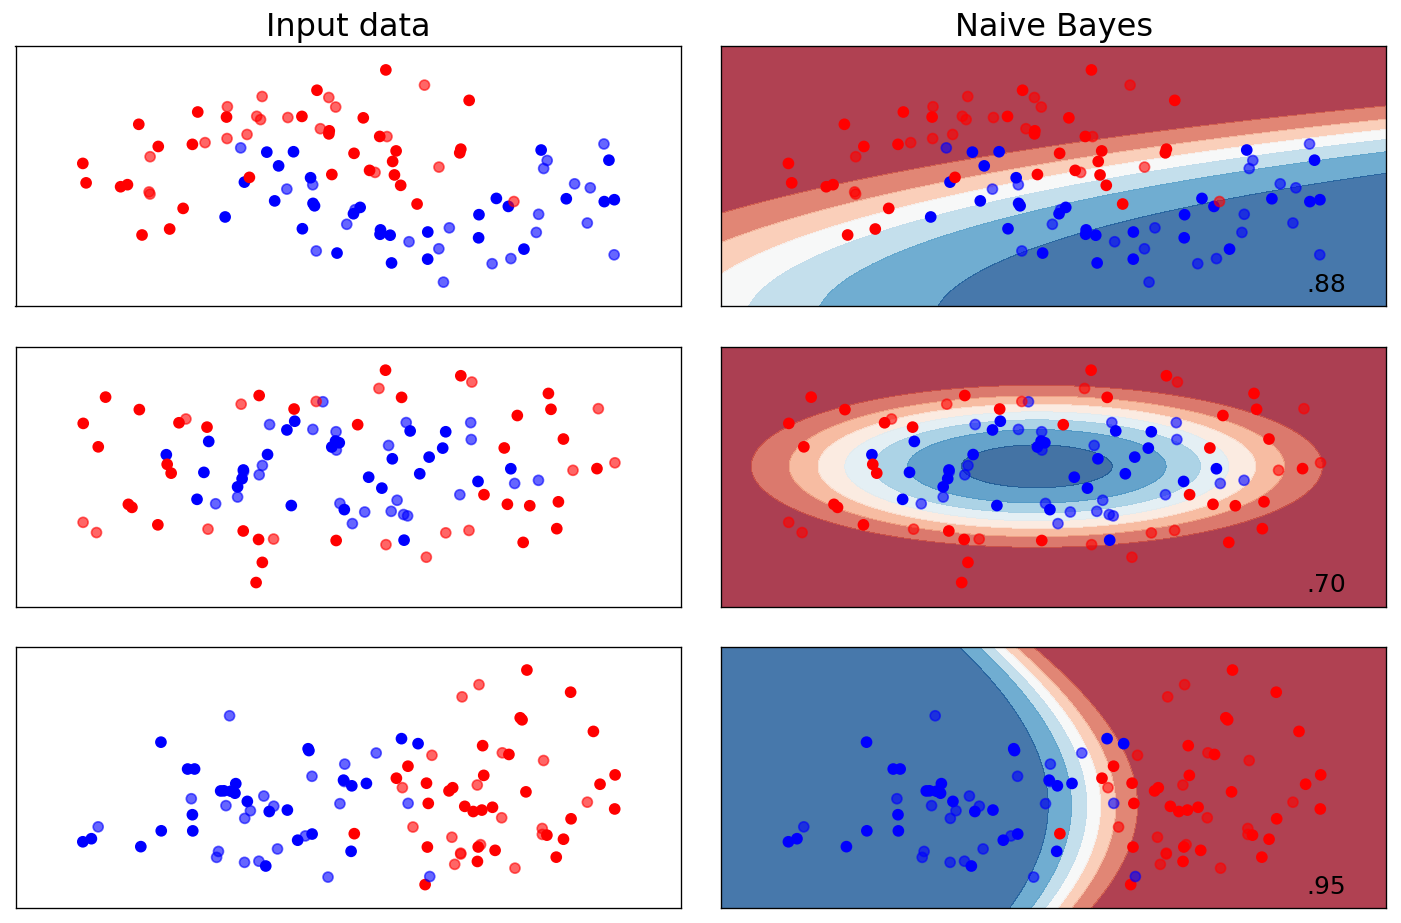

In [32]:
from sklearn.naive_bayes import GaussianNB
import plot_classifiers as pc

names = ["Naive Bayes"]
classifiers = [GaussianNB()]

plt.rcParams.update({'font.size': 16})
pc.plot_classifiers(names, classifiers, figuresize=(12,8))

Other Naive Bayes classifiers:
    
* BernoulliNB
    * Assumes binary data
    * Feature statistics: Number of non-zero entries per class
* MultinomialNB
    * Assumes count data
    * Feature statistics: Average value per class

Mostly used for text classification (bag-of-words data)

### Probabilistic interpretation of regression
Let's look at a the following regression problem

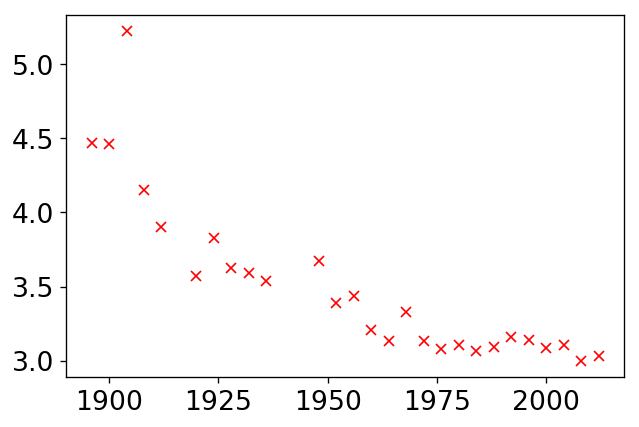

In [4]:
data = pods.datasets.olympic_marathon_men()
x = data['X']
y = data['Y']
plt.plot(x, y, 'rx')

Let's first try to fit a linear model 

$$f(\mathbf{x}_i) = \mathbf{x}_i^\top\mathbf{w}$$

We can solve this via linear algebra by making a design matrix of the data, which includes the  $x_0=1$ column, to represent the bias. Hence, each vector $\mathbf{x}_i$ is given by appending a 1 onto the original vector

$$\mathbf{x}_i = 
\begin{bmatrix} 
1 \\\
x_i
\end{bmatrix}$$

We can do this for the entire data set to form a design matrix $\mathbf{X}$,

$$\mathbf{X} = \begin{bmatrix} 
\mathbf{x}_1^\top \\\ 
\mathbf{x}_2^\top \\\ 
\vdots \\\
\mathbf{x}_N^\top
\end{bmatrix} = \begin{bmatrix}
1 & x_1 \\\
1 & x_2 \\\
\vdots & \vdots \\\
1 & x_N 
\end{bmatrix},$$

which in `numpy` is done and solved with the following commands:

In [5]:
X = np.hstack((np.ones_like(x), x)) # [ones(size(x)) x]
w = np.linalg.solve(np.dot(X.T, X), np.dot(X.T, y))
print(w)

[[28.895]
 [-0.013]]


We can now fit the function

$$ y= mx +c $$

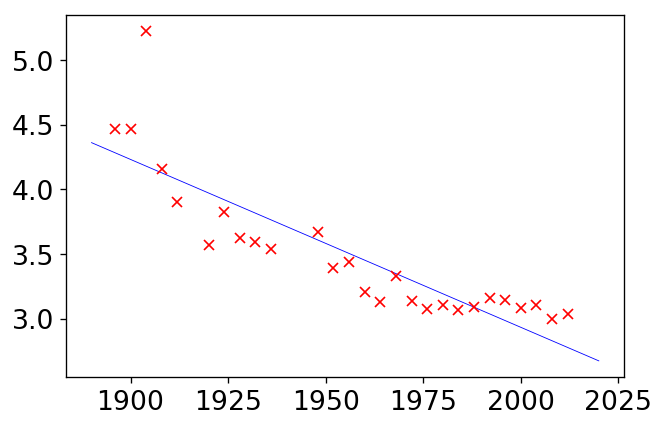

In [6]:
m = w[1]; c=w[0]
x_test = np.linspace(1890, 2020, 130)[:, None]

f_test = m*x_test + c

plt.plot(x_test, f_test, 'b-')
plt.plot(x, y, 'rx')

Now we will fit a quadratic model using more _basis functions_.  
Firstly, we need to create a new design matrix that contains the quadratic basis, 

$$\mathbf{\Phi} = \left[ \mathbf{1} \quad \mathbf{x} \quad \mathbf{x}^2\right]$$

[[643.642]
 [ -0.643]
 [  0.   ]]


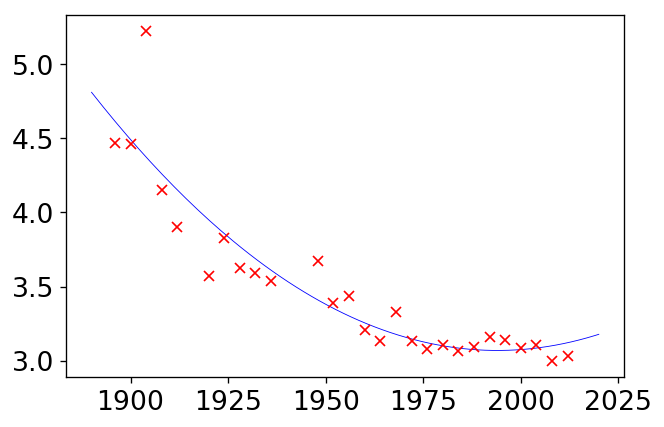

In [7]:
Phi = np.hstack([np.ones(x.shape), x, x**2])
w = np.linalg.solve(np.dot(Phi.T, Phi), np.dot(Phi.T, y))
print(w)
f_test = w[2]*x_test**2 + w[1]*x_test + w[0]
plt.plot(x_test, f_test, 'b-')
plt.plot(x, y, 'rx')

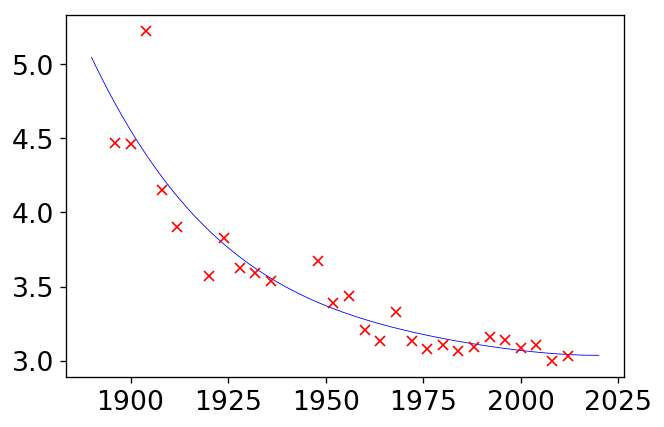

In [8]:
Phi = np.hstack([np.ones(x.shape), x, x**2, x**3, x**4, x**5, x**6])
w = np.linalg.solve(np.dot(Phi.T, Phi), np.dot(Phi.T, y))
f_test = w[6]*x_test**6 + w[5]*x_test**5 + w[4]*x_test**4 + w[3]*x_test**3 + w[2]*x_test**2 + w[1]*x_test + w[0]
plt.plot(x_test, f_test, 'b-')
plt.plot(x, y, 'rx')

## Gaussian processes

Processes where the probabilities of possible base functions are learned/updated based on new data.

![gps](images/06_gps.png)

## Probabilistic interpretation or regression

When there are more observations than unknowns (overdetermined systems), we cannot perfectly fit
$$ y = mx + c $$

This issue can be solved by assuming that the data in inherently uncertain, and model it explictly by introducing a type of [slack variable](http://en.wikipedia.org/wiki/Slack_variable), $\epsilon_i$, known as noise.

For each observation we now have the equation

$$y_i = mx_i + c + \epsilon_i.$$

The slack variable represented the difference between our actual prediction and the true observation. This is also known as the *residual*. 

We now have an additional $n$ variables to estimate, one for each data point, $\{\epsilon_i\}$. With the original $m$ and $c$ we now have $n+2$ parameters to be estimated from $n$ observations (underdetermined system).

We can however make assumptions about the noise distribution, i.e. that the slack variables are distributed according to a probability density. One often assumes Gaussian noise:

$$\epsilon_i \sim \mathcal{N}(0, \sigma^2),$$

with zero mean and variance $\sigma^2$.


In the Bayesian approach, we also assume a _prior distribution_ for the parameters, $\mathbf{w}$:

$$\mathbf{w} \sim \mathcal{N}(\mathbf{0}, \alpha \mathbf{I})$$

I.e, each element of the parameters vector, $w_i$, was drawn from a Gaussian density with variance $\alpha$
$$w_i \sim \mathcal{N}(0,\alpha)$$

Gaussian process model parameters:

- parameters of the prior
- parameters of the basis functions 
- noise level

In [9]:
# set prior variance on w
alpha = 4.
# set the order of the polynomial basis set
degree = 5
# set the noise variance
sigma2 = 0.01

Now we have the variance, we can sample from the prior distribution to see what form we are imposing on the functions *a priori*. 

In [10]:
# Build the basis matrices (on Olypics data)
def polynomial(x, degree, loc, scale):
    degrees = np.arange(degree+1)
    return ((x-loc)/scale)**degrees

scale = np.max(x) - np.min(x)
loc = np.min(x) + 0.5*scale

num_data = x.shape[0]
num_pred_data = 100 # how many points to use for plotting predictions
x_pred = np.linspace(1880, 2030, num_pred_data)[:, None] # input locations for predictions
Phi_pred = polynomial(x_pred, degree=degree, loc=loc, scale=scale)
Phi = polynomial(x, degree=degree, loc=loc, scale=scale)

### Weight Space View

To generate typical functional predictions from the model, we need a set of model parameters.  
We assume that the parameters are drawn independently from a Gaussian density,
$$
\mathbf{w} \sim \mathcal{N}(\mathbf{0}, \alpha\mathbf{I}),
$$
then we can combine this with the definition of our prediction function $f(\mathbf{x})$,
$$
f(\mathbf{x}) = \mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x}).
$$
We can now sample from the prior density to obtain a vector $\mathbf{w}$ using the function `np.random.normal` and combine these parameters with our basis to create some samples of what $f(\mathbf{x})$ looks like,

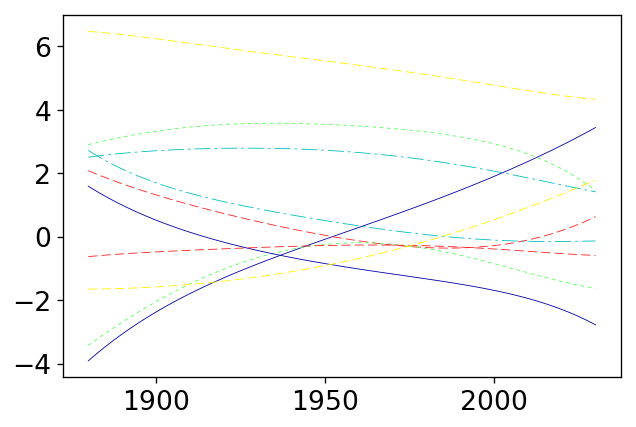

In [11]:
num_samples = 10
K = degree+1
for i in range(num_samples):
    z_vec = np.random.normal(size=(K, 1))
    w_sample = z_vec*np.sqrt(alpha)
    f_sample = np.dot(Phi_pred,w_sample)
    plt.plot(x_pred, f_sample)

### Function space view

We can use standard properties of multivariate Gaussians to write down the probability density that is implied over $\mathbf{f}$. 

We know that if $\mathbf{w}$ is sampled from a multivariate Gaussian with covariance $\alpha \mathbf{I}$ and zero mean, then assuming that $\boldsymbol{\Phi}$ is a deterministic matrix (i.e. it is not sampled from a probability density) then the vector $\mathbf{f}$ will also be distributed according to a zero mean multivariate normal as follows,
$$
\mathbf{f} \sim \mathcal{N}(\mathbf{0},\alpha \boldsymbol{\Phi} \boldsymbol{\Phi}^\top).
$$

What happens if we sample $\mathbf{f}$ directly from this density, rather than first sampling $\mathbf{w}$ and then multiplying by $\boldsymbol{\Phi}$. 

Let's try this. First of all we define the covariance (joined variability between 2 variables) as
$$
\mathbf{K} = \alpha \boldsymbol{\Phi}\boldsymbol{\Phi}^\top.
$$

In [12]:
K = alpha*np.dot(Phi_pred, Phi_pred.T)

We can use `np.random.multivariate_normal` for sampling from a multivariate normal with covariance given by $\mathbf{K}$ and zero mean,

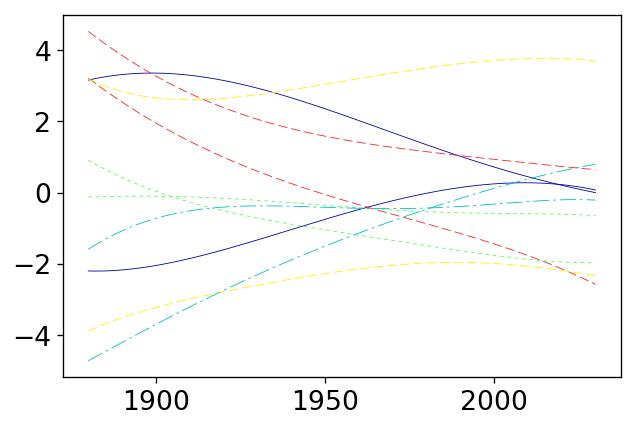

In [13]:
for i in np.arange(10):
    f_sample = np.random.multivariate_normal(mean=np.zeros(x_pred.size), cov=K)
    plt.plot(x_pred.flatten(), f_sample.flatten())

These look very similar! Indeed, they are effectively drawn from the same mutivariate normal density.

When sampling $\mathbf{f}$ directly we created the covariance for $\mathbf{f}$. We can visualise the covariance matrix: 

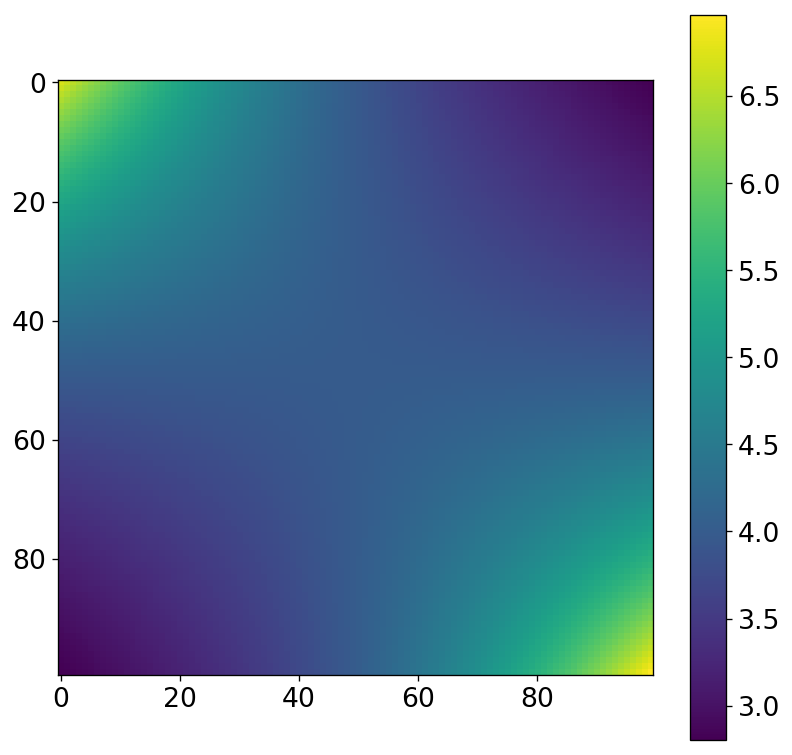

In [14]:
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(K, interpolation='none')
fig.colorbar(im)

### Noisy functions

We normally add Gaussian noise to obtain our observations: 
$$
\mathbf{y} = \mathbf{f} + \boldsymbol{\epsilon}
$$

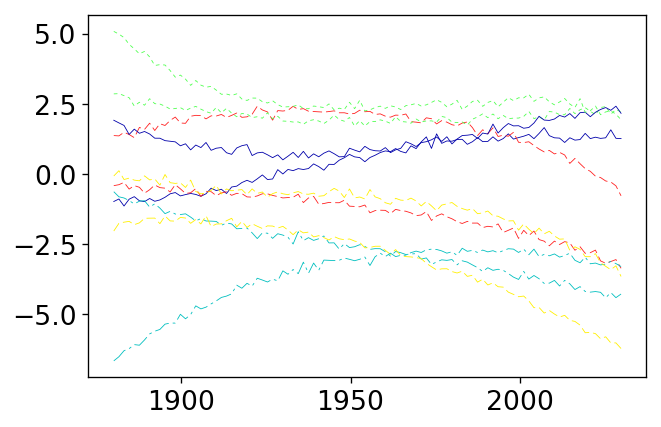

In [15]:
K = alpha*np.dot(Phi_pred, Phi_pred.T) + sigma2*np.eye(x_pred.size)
for i in range(10):
    y_sample = np.random.multivariate_normal(mean=np.zeros(x_pred.size), cov=K)
    plt.plot(x_pred.flatten(), y_sample.flatten())

We can also increase the variance of the noise

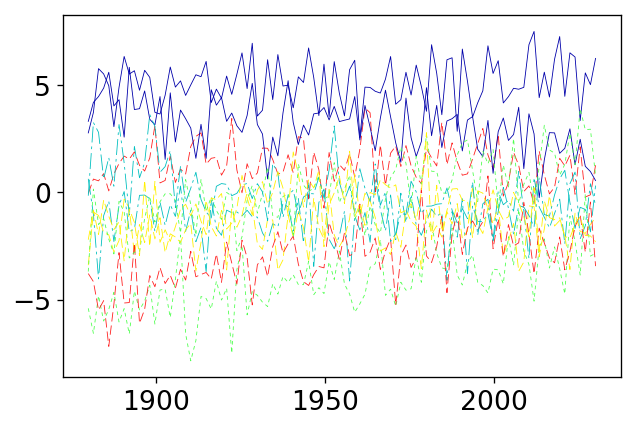

In [16]:
sigma2 = 1.
K = alpha*np.dot(Phi_pred, Phi_pred.T) + sigma2*np.eye(x_pred.size)
for i in range(10):
    y_sample = np.random.multivariate_normal(mean=np.zeros(x_pred.size), cov=K)
    plt.plot(x_pred.flatten(), y_sample.flatten())

## Gaussian Process

In a Gaussian process you specify the *covariance function* directly, rather than *implicitly* through a basis matrix and a prior over parameters. 

Gaussian processes have the advantage that they can be *nonparametric*: they can have *infinite* basis functions.

The RBF (Gaussian) covariance function is specified by
$$
k(\mathbf{x}, \mathbf{x}^\prime) = \alpha \exp\left( -\frac{\left\Vert \mathbf{x}-\mathbf{x}^\prime\right\Vert^2}{2\ell^2}\right).
$$
where $\left\Vert\mathbf{x} - \mathbf{x}^\prime\right\Vert^2$ is the squared distance between the two input vectors 
$$
\left\Vert\mathbf{x} - \mathbf{x}^\prime\right\Vert^2 = (\mathbf{x} - \mathbf{x}^\prime)^\top (\mathbf{x} - \mathbf{x}^\prime) 
$$
Let's build a covariance matrix based on this function.

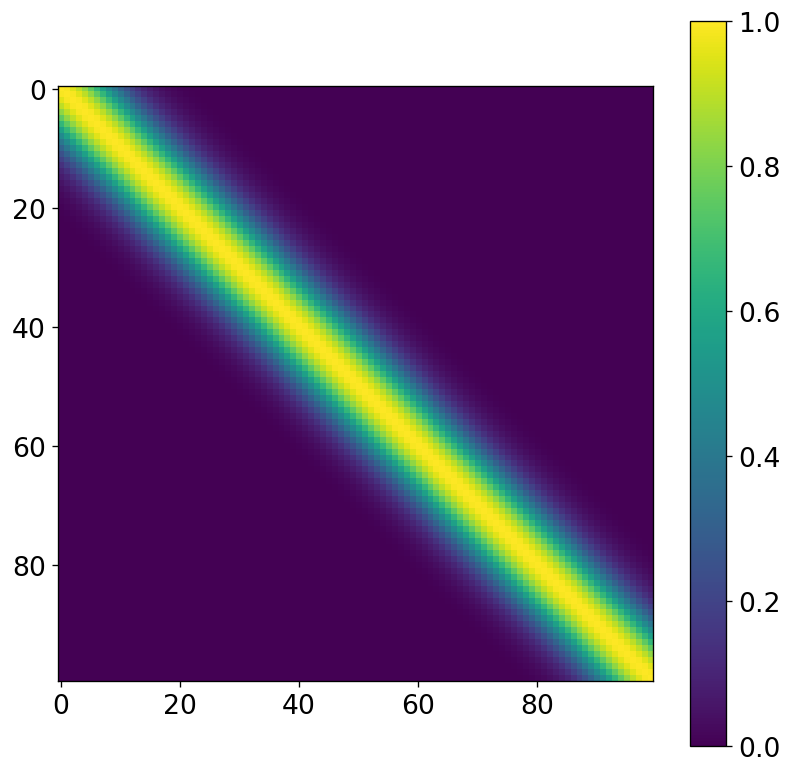

In [17]:
# Exponentiated quadratic is another name for RBF
def exponentiated_quadratic(x, x_prime, variance, lengthscale):
    squared_distance = ((x-x_prime)**2).sum()
    return variance*np.exp((-0.5*squared_distance)/lengthscale**2)

# Compute covariances directly
def compute_kernel(X, X2, kernel, **kwargs):
    K = np.zeros((X.shape[0], X2.shape[0]))
    for i in np.arange(X.shape[0]):
        for j in np.arange(X2.shape[0]):
            K[i, j] = kernel(X[i, :], X2[j, :], **kwargs)
    return K

# Visualize
K = compute_kernel(x_pred, x_pred, exponentiated_quadratic, variance=1., lengthscale=10.)
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(K, interpolation='none')
fig.colorbar(im)

Finally, we can sample functions with this kernel (covariance matrix)

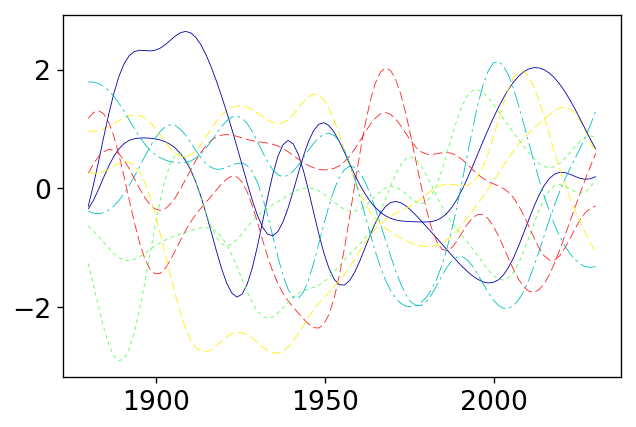

In [18]:
for i in range(10):
    y_sample = np.random.multivariate_normal(mean=np.zeros(x_pred.size), cov=K)
    plt.plot(x_pred.flatten(), y_sample.flatten())

## Gaussian process optimization

The Gaussian process perspective takes the marginal likelihood of the data to be a joint Gaussian density with a covariance given by $\mathbf{K}$. 

The model likelihood is of the form,
$$
p(\mathbf{y}|\mathbf{X}) = \frac{1}{(2\pi)^{\frac{n}{2}}|\mathbf{K}|^{\frac{1}{2}}} \exp\left(-\frac{1}{2}\mathbf{y}^\top \left(\mathbf{K}+\sigma^2 \mathbf{I}\right)^{-1}\mathbf{y}\right)
$$
where the input data, $\mathbf{X}$, influences the density through the covariance matrix, $\mathbf{K}$ whose elements are computed through the covariance function, $k(\mathbf{x}, \mathbf{x}^\prime)$.

Hence, the negative log likelihood (the objective function) is given by,
$$
E(\boldsymbol{\theta}) = \frac{1}{2} \log |\mathbf{K}| + \frac{1}{2} \mathbf{y}^\top \left(\mathbf{K} + \sigma^2\mathbf{I}\right)^{-1}\mathbf{y}
$$
where the *parameters* of the model are also embedded in the covariance function, they include the parameters of the kernel (such as lengthscale and variance), and the noise variance, $\sigma^2$.

In [19]:
class GP():
    def __init__(self, X, y, sigma2, kernel, **kwargs):
        self.K = compute_kernel(X, X, kernel, **kwargs)
        self.X = X
        self.y = y
        self.sigma2 = sigma2
        self.kernel = kernel
        self.kernel_args = kwargs
        self.update_inverse()
    
    def update_inverse(self):
        # Preompute the inverse covariance and some quantities of interest
        ## NOTE: This is not the correct *numerical* way to compute this! It is for ease of use.
        self.Kinv = np.linalg.inv(self.K+self.sigma2*np.eye(self.K.shape[0]))
        # the log determinant of the covariance matrix.
        self.logdetK = np.linalg.det(self.K+self.sigma2*np.eye(self.K.shape[0]))
        # The matrix inner product of the inverse covariance
        self.Kinvy = np.dot(self.Kinv, self.y)
        self.yKinvy = (self.y*self.Kinvy).sum()

        
    def log_likelihood(self):
        # use the pre-computes to return the likelihood
        return -0.5*(self.K.shape[0]*np.log(2*np.pi) + self.logdetK + self.yKinvy)
    
    def objective(self):
        # use the pre-computes to return the objective function 
        return -self.log_likelihood()

### Making predictions
The model makes predictions for $\mathbf{f}$ that are unaffected by future values of $\mathbf{f}^*$.  
If we think of $\mathbf{f}^*$ as test points, we can still write down a joint probability density over the training observations, $\mathbf{f}$ and the test observations, $\mathbf{f}^*$. 

This joint probability density will be Gaussian, with a covariance matrix given by our covariance function, $k(\mathbf{x}_i, \mathbf{x}_j)$. 
$$
\begin{bmatrix}\mathbf{f} \\ \mathbf{f}^*\end{bmatrix} \sim \mathcal{N}\left(\mathbf{0}, \begin{bmatrix} \mathbf{K} & \mathbf{K}_\ast \\ \mathbf{K}_\ast^\top & \mathbf{K}_{\ast,\ast}\end{bmatrix}\right)
$$

where $\mathbf{K}$ is the covariance computed between all the training points,  
$\mathbf{K}_\ast$ is the covariance matrix computed between the training points and the test points,  
$\mathbf{K}_{\ast,\ast}$ is the covariance matrix computed between all the tests points and themselves. 

## Conditional Density

Just as in naive Bayes, we defined the joint density (although there it was over both the labels and the inputs, $p(\mathbf{y}, \mathbf{X})$ and now we need to define *conditional* distributions that answer particular questions of interest. 

We will need the *conditional density* for making predictions.
$$
\mathbf{f}^* | \mathbf{y} \sim \mathcal{N}(\boldsymbol{\mu}_f,\mathbf{C}_f)
$$
with a mean given by
$$
\boldsymbol{\mu}_f = \mathbf{K}_*^\top \left[\mathbf{K} + \sigma^2 \mathbf{I}\right]^{-1} \mathbf{y}
$$
and a covariance given by 
$$
\mathbf{C}_f = \mathbf{K}_{*,*} - \mathbf{K}_*^\top \left[\mathbf{K} + \sigma^2 \mathbf{I}\right]^{-1} \mathbf{K}_\ast.
$$
Let's compute what those posterior predictions are for the olympic marathon data.

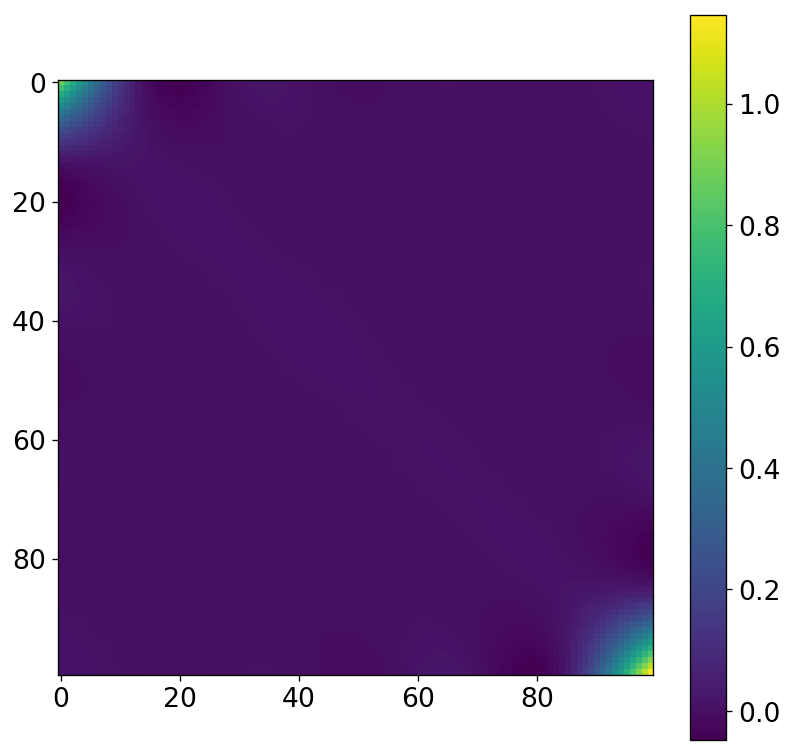

In [20]:
# set covariance function parameters
variance = 16.0
lengthscale = 32
# set noise variance
sigma2 = 0.05

def posterior_f(self, X_test):
    K_star = compute_kernel(self.X, X_test, self.kernel, **self.kernel_args)
    K_starstar = compute_kernel(X_test, X_test, self.kernel, **self.kernel_args)
    A = np.dot(self.Kinv, K_star)
    mu_f = np.dot(A.T, y)
    C_f = K_starstar - np.dot(A.T, K_star)
    return mu_f, C_f

# attach the new method to class GP():
GP.posterior_f = posterior_f

model = GP(x, y, sigma2, exponentiated_quadratic, variance=variance, lengthscale=lengthscale)
mu_f, C_f = model.posterior_f(x_pred)

fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(C_f, interpolation='none')
fig.colorbar(im)

We can now plot the mean

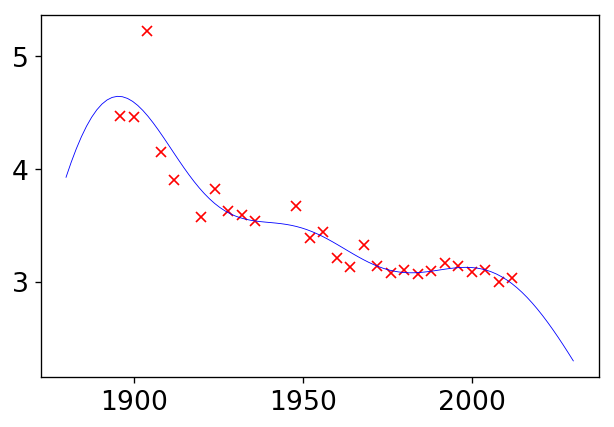

In [21]:
plt.plot(x, y, 'rx')
plt.plot(x_pred, mu_f, 'b-')

as well as the associated error bars

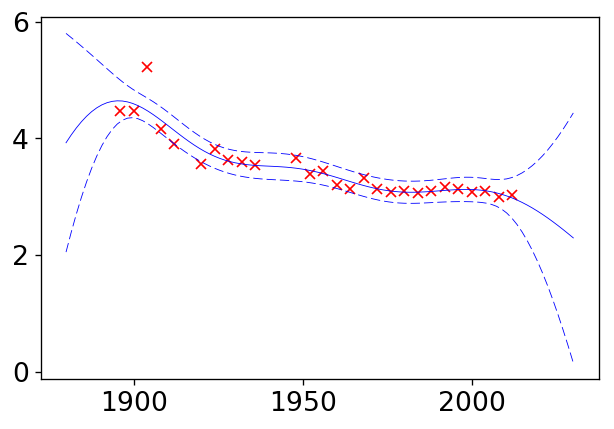

In [22]:
var_f = np.diag(C_f)[:, None]
std_f = np.sqrt(var_f)

plt.plot(x, y, 'rx')
plt.plot(x_pred, mu_f, 'b-')
plt.plot(x_pred, mu_f+2*std_f, 'b--')
plt.plot(x_pred, mu_f-2*std_f, 'b--')

## Gaussian Processes with GPy
- `GPyRegression`
- Generate a kernel first
    - State the dimensionality of your input data
    - Variance and lengthscale are optional, default = 1
```
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
```
    - Other kernels:
```
GPy.kern.BasisFuncKernel?
```
- Build model:
```
m = GPy.models.GPRegression(X,Y,kernel)
```


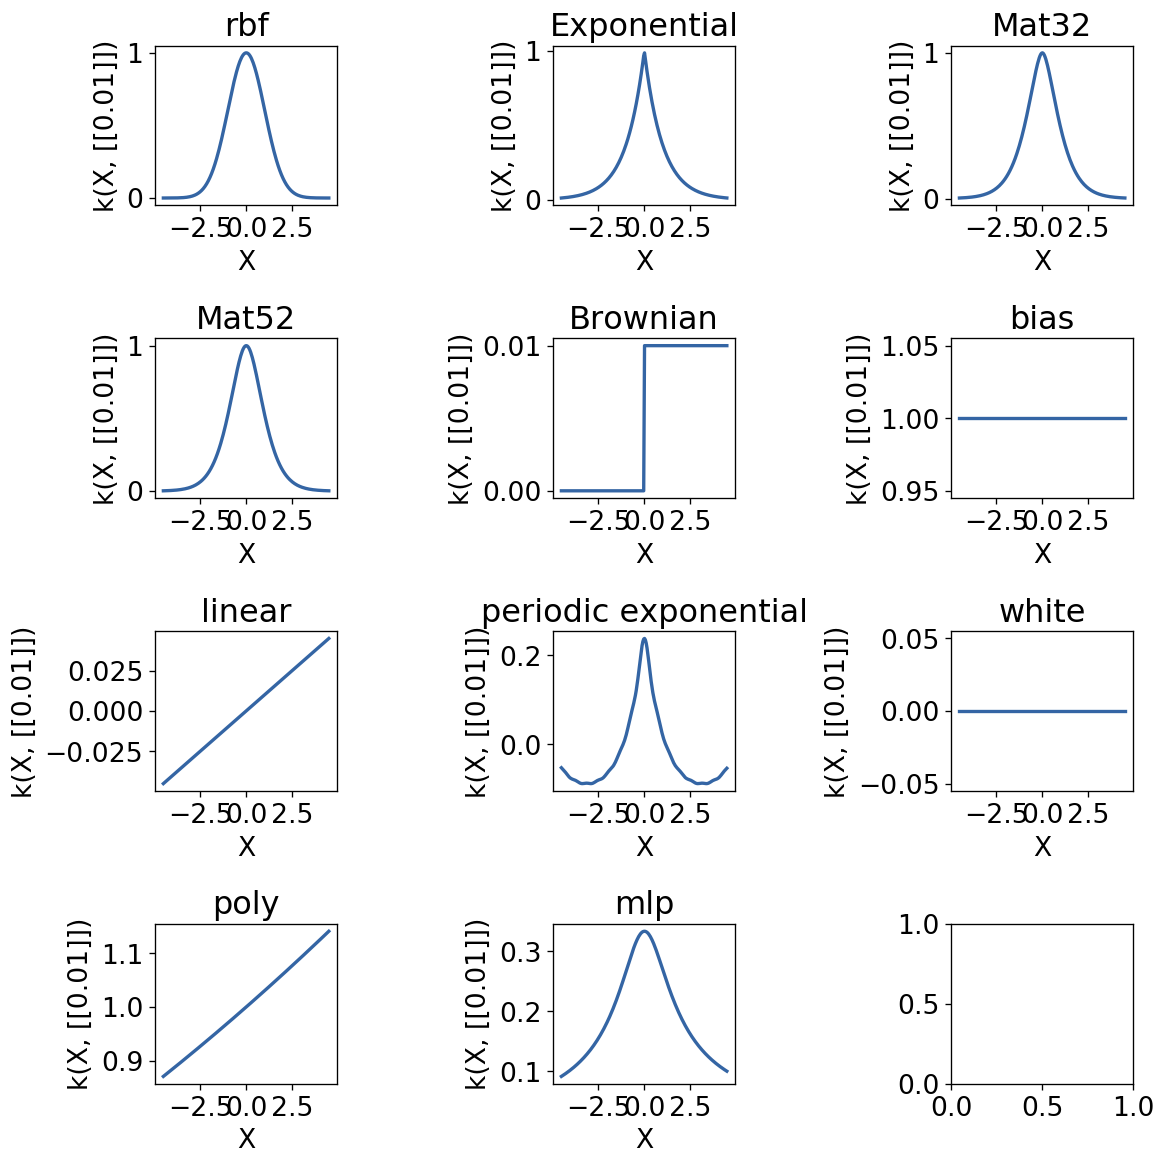

In [23]:
figure, axes = plt.subplots(4,3, figsize=(10,10), tight_layout=True)
kerns = [GPy.kern.RBF(1), GPy.kern.Exponential(1), GPy.kern.Matern32(1), 
         GPy.kern.Matern52(1), GPy.kern.Brownian(1),GPy.kern.Bias(1), 
         GPy.kern.Linear(1), GPy.kern.PeriodicExponential(1), GPy.kern.White(1), 
         GPy.kern.Poly(1), GPy.kern.MLP(1)]

for k,a in zip(kerns, axes.flatten()):
    k.plot(ax=a, x=0.01)
    a.set_title(k.name.replace('_', ' '))

`Matern` is a generalized RBF kernel that can scale between RBF and Exponential

Build the untrained GP. The shaded region corresponds to ~95% confidence intervals (i.e. +/- 2 standard deviation)

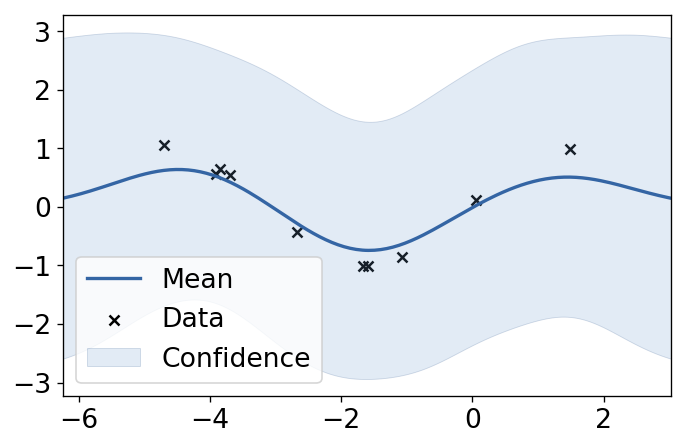

In [24]:
# Generate noisy sine data
X = np.random.uniform(-5.,5.,(10,1))
Y = np.sin(X) + np.random.randn(10,1)*0.05

# Build untrained model
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
m = GPy.models.GPRegression(X,Y,kernel)
fig = m.plot()

Train the model (optimize the parameters): maximize the likelihood of the data.  
Best to optimize with a few restarts: the optimizer may converges to the high-noise solution. The optimizer is then restarted with a few random initialization of the parameter values.  

Optimization restart 1/10, f = -0.724634445436255
Optimization restart 2/10, f = -0.7246344454195306
Optimization restart 3/10, f = -0.7246344454362248
Optimization restart 4/10, f = -0.7246344454362221
Optimization restart 5/10, f = -0.7246344454361902
Optimization restart 6/10, f = -0.7246344454359583
Optimization restart 7/10, f = -0.724634445417216
Optimization restart 8/10, f = -0.7246344454362887
Optimization restart 9/10, f = -0.724634445426374
Optimization restart 10/10, f = -0.7246344454351004


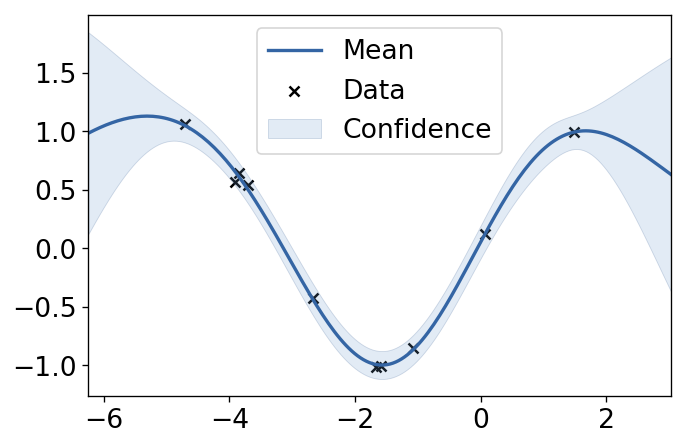

In [25]:
m.optimize_restarts(num_restarts = 10)
fig = m.plot()

You can also plot densities

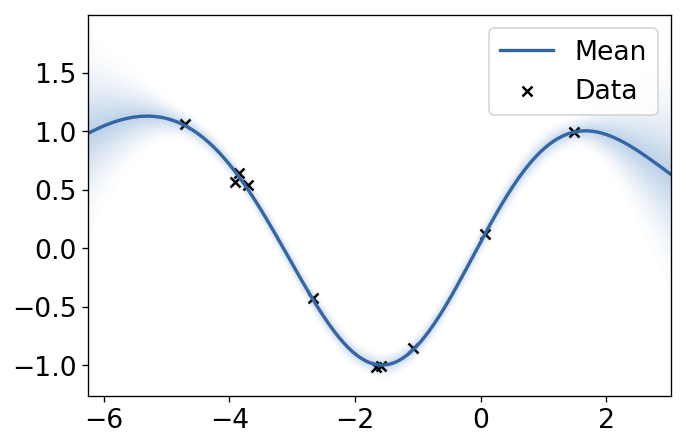

In [26]:
fig = m.plot(plot_density=True)

You can also show results in 2D

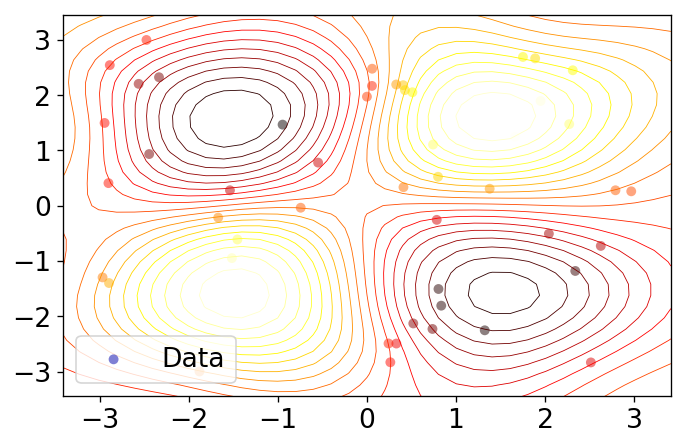

In [27]:
# sample inputs and outputs
X = np.random.uniform(-3.,3.,(50,2))
Y = np.sin(X[:,0:1]) * np.sin(X[:,1:2])+np.random.randn(50,1)*0.05

# define kernel
ker = GPy.kern.Matern52(2,ARD=True) + GPy.kern.White(2)

# create simple GP model
m = GPy.models.GPRegression(X,Y,ker)

# optimize and plot
m.optimize(max_f_eval = 1000)
fig = m.plot()

We can plot 2D slices using the `fixed_inputs` argument to the plot function.  
`fixed_inputs` is a list of tuples containing which of the inputs to fix, and to which value.

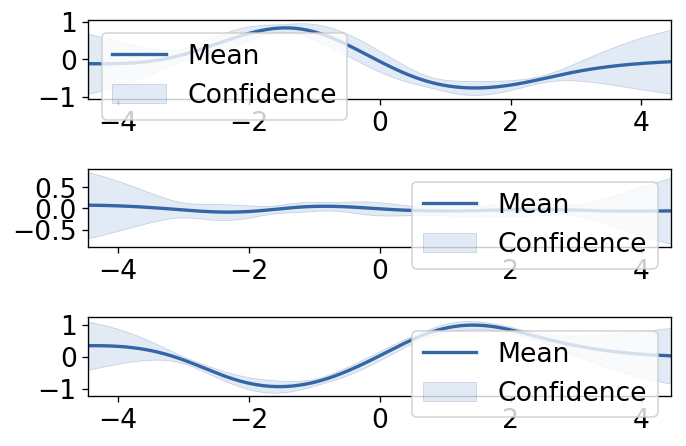

In [28]:
slices = [-1, 0, 1.5]
figure = GPy.plotting.plotting_library().figure(3, 1)
for i, y in zip(range(3), slices):
    canvas = m.plot(figure=figure, fixed_inputs=[(1,y)], row=(i+1), plot_data=False)

For vertical slices, simply fix the other input: `fixed_inputs=[(0,y)]`

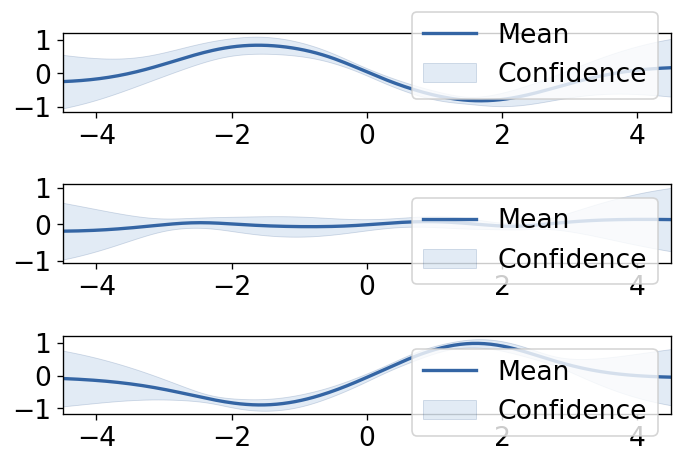

In [29]:
slices = [-1, 0, 1.5]
figure = GPy.plotting.plotting_library().figure(3, 1)
for i, y in zip(range(3), slices):
    canvas = m.plot(figure=figure, fixed_inputs=[(0,y)], row=(i+1), plot_data=False)

## Gaussian Processes with scikit-learn
- `GaussianProcessRegressor`
- Hyperparameters:
    - `kernel`: kernel specifying the covariance function of the GP
        - Default: "1.0 * RBF(1.0)"
        - Typically leave at default. Will be optimized during fitting
    - `alpha`: regularization parameter 
        - Tikhonov regularization of the assumed covariance between the training points.
        - Adds a (small) value to the diagonal of the kernel matrix during fitting. 
        - Larger values:
            - correspond to increased noise level in the observations
            - also reduce potential numerical issues during fitting
        - Default: 1e-10
    - `n_restarts_optimizer`: number of restarts of the optimizer
        - Default: 0. Best to do at least a few iterations.
        - Optimizer finds the kernel’s parameters which maximize the log-marginal likelihood
- Retrieve predictions and confidence interval after fitting:
```
y_pred, sigma = gp.predict(x, return_std=True)
```

Example

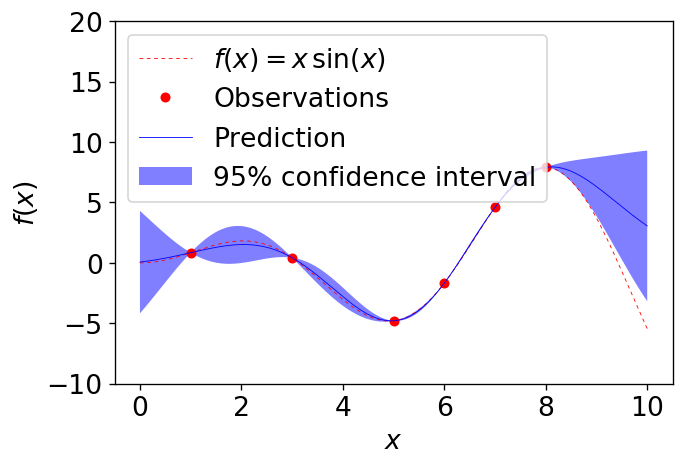

In [30]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

def f(x):
    """The function to predict."""
    return x * np.sin(x)

X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T

# Observations
y = f(X).ravel()

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.atleast_2d(np.linspace(0, 10, 1000)).T

# Instanciate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
fig = plt.figure()
plt.plot(x, f(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'r.', markersize=10, label=u'Observations')
plt.plot(x, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')

Example with noisy data

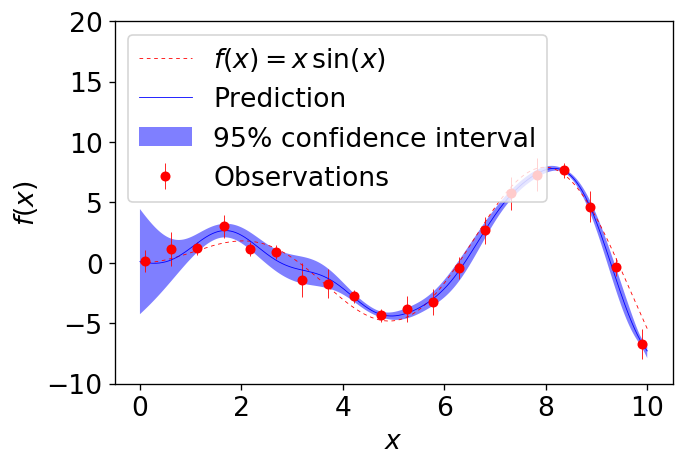

In [31]:
X = np.linspace(0.1, 9.9, 20)
X = np.atleast_2d(X).T

# Observations and noise
y = f(X).ravel()
dy = 0.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise

# Instanciate a Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, alpha=(dy / y) ** 2,
                              n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
fig = plt.figure()
plt.plot(x, f(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
plt.errorbar(X.ravel(), y, dy, fmt='r.', markersize=10, label=u'Observations')
plt.plot(x, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')

plt.show()

# Gaussian processes

The advantages of Gaussian processes are:
- The prediction interpolates the observations (at least for regular kernels).
- The prediction is probabilistic (Gaussian) so that one can compute empirical confidence intervals.
- Versatile: different kernels can be specified.
    
The disadvantages of Gaussian processes include:
- They are not sparse, i.e., they use the whole samples/features information to perform the prediction.
- They lose efficiency in high dimensional spaces – namely when the number of features exceeds a few dozens.

